In [225]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import size, array_max, array_min, udf
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import size
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import NaiveBayes, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from pyspark.sql.functions import col, hour, dayofweek, when, count, mean, stddev,to_date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [226]:
spark = SparkSession.builder \
    .appName("NYC_Taxi_Analysis") \
    .getOrCreate()

spark

In [227]:
data = spark.read.csv(
    "taxi_2024_dec.csv",  
    header=True,
    inferSchema=True
)

In [228]:
data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- Airport_fee: string (nullable = true)



In [229]:
data.show(35)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-12-01 00:12:27|  2024-12-01 00:31:12|              1|         9.76|         1|                 N|         138|          33|           1|       38.0|  6.0|    0.5|      4.7

In [230]:
data.describe(["passenger_count", "trip_distance", "fare_amount", "tip_amount", "total_amount"]).show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|       tip_amount|      total_amount|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|           3668371|           3668371|           3668371|          3668371|           3668371|
|   mean|  1.36244225153198| 5.087801326528824|19.661293004442253|3.459467545675839|28.320414281981286|
| stddev|0.8233150946191511|472.83206292608594|19.818889937036584|4.180590909185161|24.645293825233704|
|    min|                 0|               0.0|            -975.0|            -80.0|            -951.0|
|    max|                \N|         328827.63|            3033.1|            471.0|            3037.1|
+-------+------------------+------------------+------------------+-----------------+------------------+



In [231]:
print(f"Total number of Rows: {data.count()}")

Total number of Rows: 3668371


data = data.withColumn("passenger_count",
                       when((col("passenger_count").isNull()) | (col("passenger_count") == "\\N"), 1)
                       .otherwise(col("passenger_count").cast("integer")))

In [233]:
passenger_condition = (col("passenger_count").isNull()) | (col("passenger_count") == "\\N")

data = data.withColumn(
    "passenger_count",
    when(passenger_condition, 1)
    .otherwise(col("passenger_count").cast("integer"))
)

In [234]:
data = data.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("total_amount") >= 0)
)

Removing rows with zero trip_distance 

In [236]:
data = data.filter(col("trip_distance") > 0)

In [237]:
data.describe(["passenger_count", "trip_distance", "fare_amount", "tip_amount", "total_amount"]).show()

+-------+------------------+-----------------+------------------+-----------------+------------------+
|summary|   passenger_count|    trip_distance|       fare_amount|       tip_amount|      total_amount|
+-------+------------------+-----------------+------------------+-----------------+------------------+
|  count|           3519975|          3519975|           3519975|          3519975|           3519975|
|   mean|1.3301486516239462| 5.14061899303258|20.391017407793722|3.549092422530981|  29.3781028643687|
| stddev|0.7927183951624491|472.6335201778042|18.108444374611814|4.138809353313388|22.740203560865478|
|    min|                 0|             0.01|               0.0|              0.0|               0.0|
|    max|                 9|        328827.63|            3033.1|            471.0|            3037.1|
+-------+------------------+-----------------+------------------+-----------------+------------------+



Checking new total number of  rows

In [239]:
print(f"Total Rows after cleaning: {data.count()}")

Total Rows after cleaning: 3519975


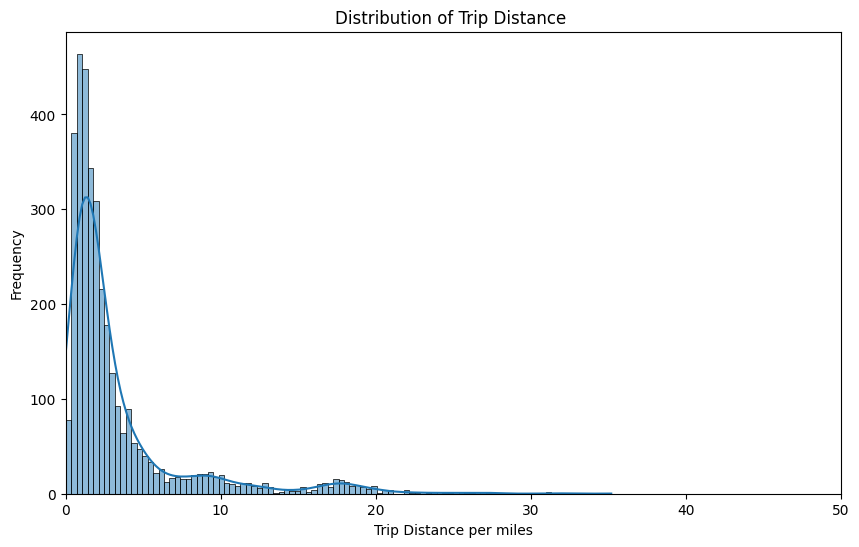

In [240]:
sample_data = data.select("trip_distance").sample(fraction=0.001).toPandas()

plt.figure(figsize=(10,6))
sns.histplot(sample_data["trip_distance"], bins=100, kde=True)
plt.title("Distribution of Trip Distance ")
plt.xlabel("Trip Distance per miles")
plt.ylabel("Frequency")
plt.xlim(0, 50)
plt.show()

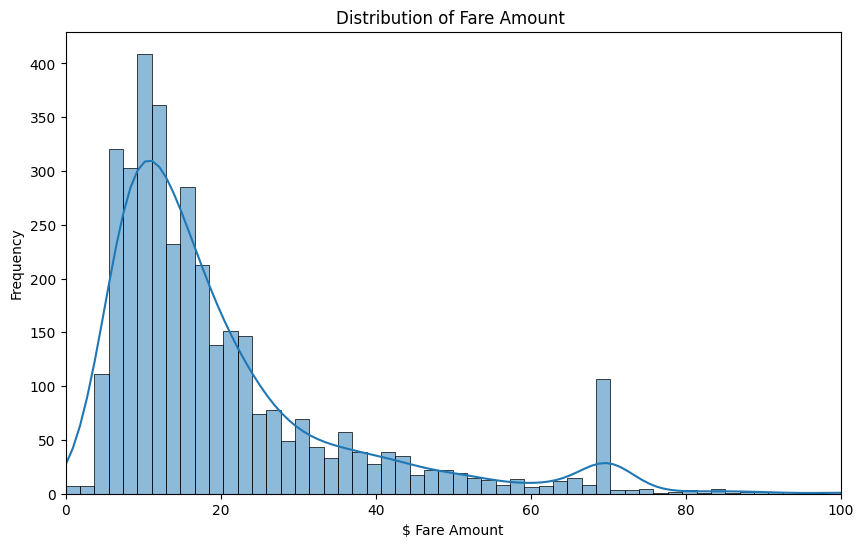

In [241]:
sample_data = data.select("fare_amount").sample(fraction=0.001).toPandas()

plt.figure(figsize=(10,6))
sns.histplot(sample_data["fare_amount"], bins=100, kde=True)
plt.title("Distribution of Fare Amount ")
plt.xlabel("$ Fare Amount")
plt.ylabel("Frequency")
plt.xlim(0, 100)
plt.show()

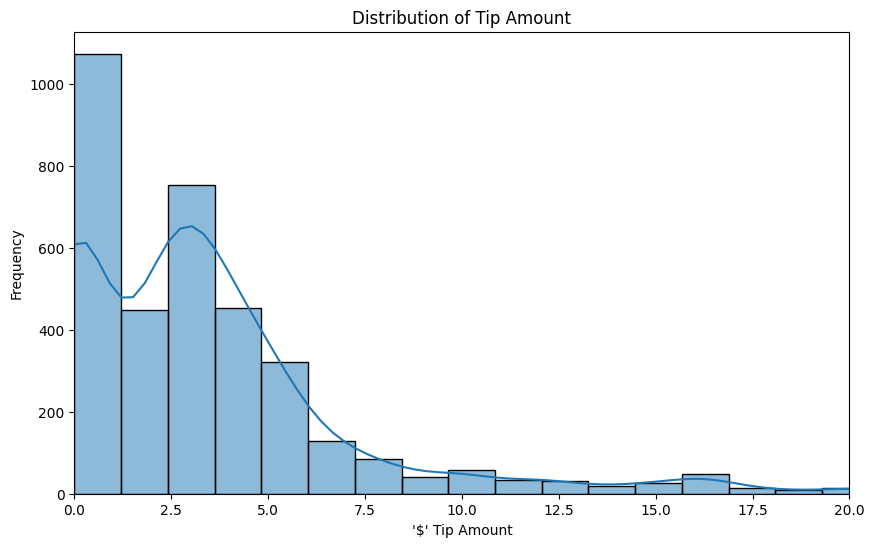

In [242]:
sample_data = data.select("tip_amount").sample(fraction=0.001).toPandas()

plt.figure(figsize=(10,6))
sns.histplot(sample_data["tip_amount"], bins=50, kde=True)
plt.title("Distribution of Tip Amount")
plt.xlabel("'$' Tip Amount")
plt.ylabel("Frequency")
plt.xlim(0, 20)
plt.show()

In [243]:
grouped_data = data.groupBy(col("passenger_count"))
counted_data = grouped_data.count()
passenger_counts = counted_data.orderBy(col("passenger_count"))

In [244]:
passenger_counts.show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              0|  29156|
|              1|2741150|
|              2| 489671|
|              3| 128653|
|              4|  95195|
|              5|  22059|
|              6|  14081|
|              7|      4|
|              8|      4|
|              9|      2|
+---------------+-------+



In [245]:
data = data.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

In [246]:
hourly_group = data.groupBy(col("pickup_hour"))
hourly_counts = hourly_group.count()
trips_by_hour = hourly_counts.orderBy(col("pickup_hour"))

In [247]:
trips_by_hour.show()

+-----------+------+
|pickup_hour| count|
+-----------+------+
|          0|104087|
|          1| 62615|
|          2| 38438|
|          3| 24819|
|          4| 19396|
|          5| 20633|
|          6| 43963|
|          7| 89136|
|          8|125324|
|          9|140924|
|         10|158456|
|         11|176456|
|         12|193073|
|         13|199415|
|         14|215941|
|         15|226897|
|         16|223953|
|         17|235861|
|         18|245543|
|         19|219240|
+-----------+------+
only showing top 20 rows



In [248]:
trips_by_hour_pd = trips_by_hour.toPandas()

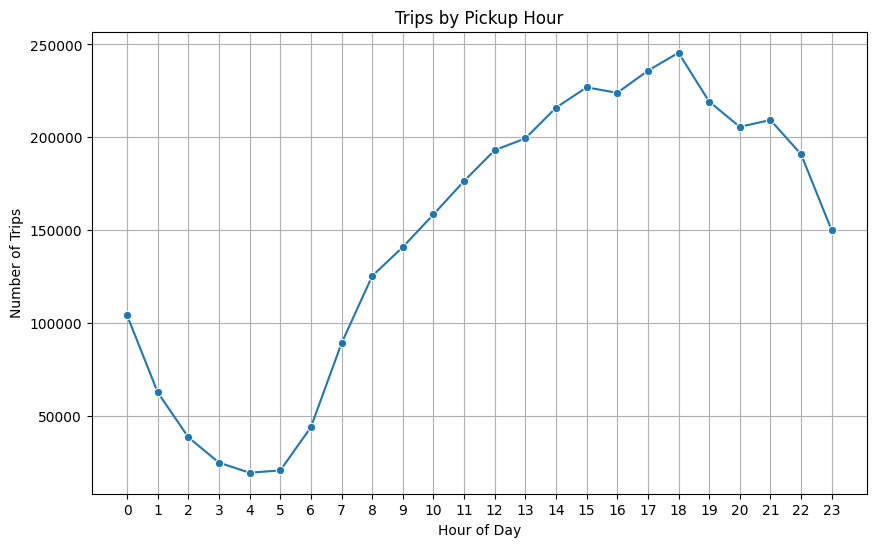

In [249]:
plt.figure(figsize=(10,6))
sns.lineplot(x="pickup_hour", y="count", data=trips_by_hour_pd, marker="o")
plt.title("Trips by Pickup Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0,24))
plt.grid()
plt.show()

In [250]:
pickup_day_column = dayofweek(col("tpep_pickup_datetime"))
data = data.withColumn("pickup_day", pickup_day_column)

In [251]:
grouped_by_day = data.groupBy(col("pickup_day"))
counted_by_day = grouped_by_day.count()
trips_by_day = counted_by_day.orderBy(col("pickup_day"))

In [252]:
trips_by_day.show()

+----------+------+
|pickup_day| count|
+----------+------+
|         1|505396|
|         2|500303|
|         3|543005|
|         4|453957|
|         5|503122|
|         6|507751|
|         7|506441|
+----------+------+



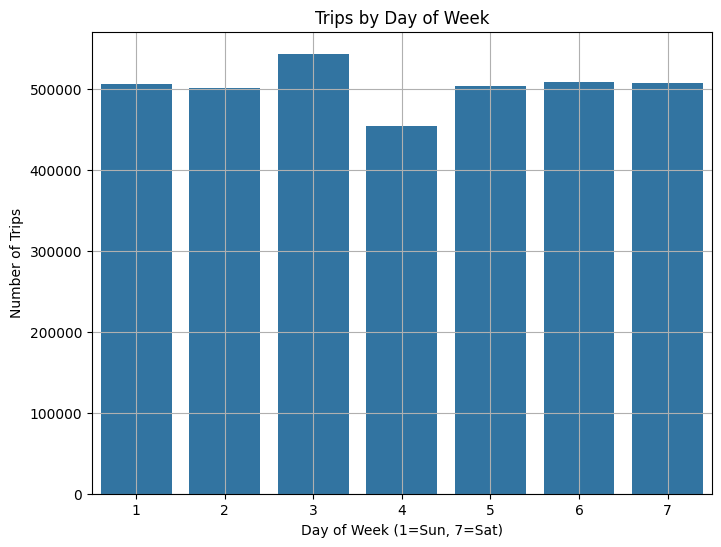

In [253]:
trips_by_day_pd = trips_by_day.toPandas()

plt.figure(figsize=(8,6))
sns.barplot(x="pickup_day", y="count", data=trips_by_day_pd)
plt.title("Trips by Day of Week")
plt.xlabel("Day of Week (1=Sun, 7=Sat)")
plt.ylabel("Number of Trips")
plt.grid()
plt.show()

In [254]:
pickup_hour_column = hour(col("tpep_pickup_datetime"))
data = data.withColumn("pickup_hour", pickup_hour_column)

In [255]:
grouped_by_hour = data.groupBy(col("pickup_hour"))
avg_fare = grouped_by_hour.avg("fare_amount")
avg_fare_by_hour = avg_fare.orderBy(col("pickup_hour"))

In [256]:
avg_fare_by_hour.show()

+-----------+------------------+
|pickup_hour|  avg(fare_amount)|
+-----------+------------------+
|          0|20.634402086715895|
|          1|18.629704224227417|
|          2|16.640832249336597|
|          3|18.240703090374314|
|          4|25.617855743452257|
|          5|29.643453206029175|
|          6|23.300591633873942|
|          7|19.937882561479118|
|          8|18.996333822731454|
|          9| 18.74034117680447|
|         10| 19.25520680819912|
|         11| 19.70215096114609|
|         12| 20.31053062831156|
|         13|21.079782313266286|
|         14| 22.00689868991984|
|         15|22.004955111790782|
|         16|  22.2406854116712|
|         17|20.992155676436514|
|         18| 19.48158367373537|
|         19| 19.34671611019886|
+-----------+------------------+
only showing top 20 rows



In [257]:
pickup_day_column = dayofweek(col("tpep_pickup_datetime"))
data = data.withColumn("pickup_day", pickup_day_column)

In [258]:
grouped_by_day = data.groupBy(col("pickup_day"))
counted_trips = grouped_by_day.count()
trips_by_day = counted_trips.orderBy(col("pickup_day"))

In [259]:
trips_by_day.show()

+----------+------+
|pickup_day| count|
+----------+------+
|         1|505396|
|         2|500303|
|         3|543005|
|         4|453957|
|         5|503122|
|         6|507751|
|         7|506441|
+----------+------+



In [260]:
grouped_by_passenger = data.groupBy(col("passenger_count"))
average_distance = grouped_by_passenger.avg("trip_distance")
avg_distance_by_passenger = average_distance.orderBy(col("passenger_count"))

In [261]:
avg_distance_by_passenger.show()

+---------------+------------------+
|passenger_count|avg(trip_distance)|
+---------------+------------------+
|              0|2.6783691178488143|
|              1| 5.519721445378697|
|              2|3.9146675216624947|
|              3|3.7115892361623897|
|              4|3.9260247912180235|
|              5| 3.293492452060384|
|              6|3.2325708401391973|
|              7|            10.925|
|              8|             0.085|
|              9|             9.085|
+---------------+------------------+



In [262]:
grouped_by_payment = data.groupBy(col("payment_type"))
average_tip = grouped_by_payment.avg("tip_amount")
tip_by_payment = average_tip.orderBy(col("payment_type"))

In [263]:
tip_by_payment.show()

+------------+--------------------+
|payment_type|     avg(tip_amount)|
+------------+--------------------+
|           0|   1.290529661382736|
|           1|   4.473400516060833|
|           2|2.297290883752637...|
|           3|0.007077688330388116|
|           4|0.009107424032337665|
+------------+--------------------+



In [264]:
pickup_date_column = to_date(col("tpep_pickup_datetime"))
data = data.withColumn("pickup_date", pickup_date_column)

In [265]:
grouped_by_date = data.groupBy(col("pickup_date"))
total_revenue = grouped_by_date.sum("total_amount")
revenue_by_day = total_revenue.orderBy(col("pickup_date"))


In [266]:
revenue_by_day.show()

+-----------+------------------+
|pickup_date| sum(total_amount)|
+-----------+------------------+
| 2008-12-31|128.98000000000002|
| 2009-01-01|             60.89|
| 2024-11-30| 735.6200000000002|
| 2024-12-01|2875292.3699997594|
| 2024-12-02|3426823.2799997106|
| 2024-12-03|3795732.9999997052|
| 2024-12-04|3920904.6199998325|
| 2024-12-05| 4378056.819999654|
| 2024-12-06| 4238201.179999826|
| 2024-12-07|3899184.7499998123|
| 2024-12-08|3501426.5899997316|
| 2024-12-09| 3524479.399999838|
| 2024-12-10|4056618.8599997875|
| 2024-12-11| 4259205.999999774|
| 2024-12-12|  4773828.28999982|
| 2024-12-13|  4490826.89999971|
| 2024-12-14| 4214785.589999889|
| 2024-12-15|3525187.1599996914|
| 2024-12-16| 3283737.729999901|
| 2024-12-17| 3598943.909999917|
+-----------+------------------+
only showing top 20 rows



In [267]:
data.write \
    .option("header", True) \
    .mode("overwrite") \
    .csv("cleaned_taxi_dec2024")

In [268]:
data = spark.read.csv(
    "cleaned_taxi_dec2024",
    header=True,
    inferSchema=True
)

In [269]:
data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- Airport_fee: string (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_date: date (nullable = true

In [270]:
print(f"Total number of Cleaned Rows: {data.count()}")

Total number of Cleaned Rows: 3519975


# Task 1 Using Naive Bayes for Tip prediction

In [476]:
data = data.withColumn(
    "tipped",
    when(col("tip_amount") > 0, 1).otherwise(0)
)

In [478]:
data = data.withColumn(
    "passenger_count",
    col("passenger_count").cast("integer")
)


In [480]:
data = data.dropna(subset=["trip_distance", "fare_amount", "passenger_count"])

In [482]:
feature_cols = ["trip_distance", "fare_amount", "passenger_count"]

In [484]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)


In [486]:
assembled = assembler.transform(data)

In [488]:
assembled = assembled.dropna(subset=["payment_type"])


In [490]:
def clip_negative(features):
    values = [max(v, 0.0) for v in features.values]
    return Vectors.dense(values)

In [492]:
clip_negative_udf = udf(clip_negative, VectorUDT())

In [494]:
train_data, test_data = assembled.randomSplit([0.7, 0.3], seed=42)

In [496]:
train_data = train_data.withColumnRenamed("tipped", "label")
test_data = test_data.withColumnRenamed("tipped", "label")


In [498]:
train_data = train_data.withColumn("features_array", vector_to_array("features"))
test_data = test_data.withColumn("features_array", vector_to_array("features"))

In [500]:
nb_simple = NaiveBayes(featuresCol="features", labelCol="label")


model_nb_simple = nb_simple.fit(train_data)
predictions_nb_simple = model_nb_simple.transform(test_data)


evaluator_nb_simple = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


accuracy_nb_simple = evaluator_nb_simple.evaluate(predictions_nb_simple)

print(f"Accuracy of Simple Naive Bayes Model (Before Tuning): {accuracy_nb_simple:.2f}")

Accuracy of Simple Naive Bayes Model (Before Tuning): 0.75


In [501]:
nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")

In [502]:
paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 1.5]) \
    .build()

In [503]:
crossval_nb = CrossValidator(
    estimator=nb,
    estimatorParamMaps=paramGrid_nb,
    evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"),
    numFolds=3
)

In [508]:
cvModel_tip = crossval_nb.fit(train_data)

In [509]:
predictions_tip_cv = cvModel_tip.transform(test_data)
evaluator_tip = BinaryClassificationEvaluator(labelCol="label")
roc_auc_tip_cv = evaluator_tip.evaluate(predictions_tip_cv)
print(f" Tip Prediction for Cross Validated ROC AUC: {roc_auc_tip_cv:.2f}")

 Tip Prediction for Cross Validated ROC AUC: 0.53


In [510]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_nb_cv = evaluator_accuracy.evaluate(predictions_tip_cv)
print(f"Tuned Naive Bayes Model Accuracy (After Tuning): {accuracy_nb_cv:.2f}")

Tuned Naive Bayes Model Accuracy (After Tuning): 0.75


In [511]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_nb_cv = evaluator_f1.evaluate(predictions_tip_cv)
print(f"Tuned Naive Bayes Model F1 Score (After Tuning): {f1_nb_cv:.2f}")


Tuned Naive Bayes Model F1 Score (After Tuning): 0.65


In [512]:
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision_nb_cv = evaluator_precision.evaluate(predictions_tip_cv)
print(f"Tuned Naive Bayes Model Precision (After Tuning): {precision_nb_cv:.2f}")

Tuned Naive Bayes Model Precision (After Tuning): 0.67


In [513]:
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall_nb_cv = evaluator_recall.evaluate(predictions_tip_cv)
print(f"Tuned Naive Bayes Model Recall (After Tuning): {recall_nb_cv:.2f}")

Tuned Naive Bayes Model Recall (After Tuning): 0.75


In [514]:
print("Parameters for best model for Tip Prediction using Naive Bayes:")
best_nb_tip = cvModel_tip.bestModel
print(f"  • smoothing: {best_nb_tip.getOrDefault('smoothing')}")
print(f"  • modelType: {best_nb_tip.getOrDefault('modelType')}")


Parameters for best model for Tip Prediction using Naive Bayes:
  • smoothing: 0.5
  • modelType: multinomial


In [515]:
nb_model = nb.fit(train_data)

Evaluation of model

In [553]:
predictions_nb = nb_model.transform(test_data)
predictions_nb.select("label", "prediction", "probability").show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.07294798824948...|
|    0|       0.0|[0.53206774270301...|
|    0|       1.0|[0.15792013846687...|
|    1|       1.0|[0.13142430856939...|
|    0|       1.0|[0.41287741849617...|
|    0|       1.0|[0.39597427387540...|
|    0|       1.0|[0.15651074560815...|
|    1|       1.0|[0.06345154398142...|
|    0|       1.0|[0.13253771752660...|
|    1|       1.0|[0.14905612175613...|
+-----+----------+--------------------+
only showing top 10 rows



In [518]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

In [543]:
accuracy_nb = evaluator.evaluate(predictions)
print(f" Naive Bayes Models accuracy after finning tunning: {accuracy_nb:.2f}")

 Naive Bayes Models accuracy after finning tunning: 0.75


In [523]:
best_nb_model = cvModel_tip.bestModel

print(" Parameters best for Naive Bayes after fine tunning:")
print(f"  • smoothing: {best_nb_model.getOrDefault('smoothing')}")
print(f"  • Type of model: {best_nb_model.getOrDefault('modelType')}")


 Parameters best for Naive Bayes after fine tunning:
  • smoothing: 0.5
  • Type of model: multinomial


In [525]:
nb_model.write().overwrite().save("/Users/pratikaher01/Documents/dic_project/CSE587Project/saved_models/naive_bayes_model")

In [545]:
with open("/Users/pratikaher01/Documents/dic_project/CSE587Project/outputs/metrics/nb_accuracy.txt", "w") as f:
    f.write(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")

In [557]:
predictions_nb.write.mode("overwrite").parquet("/Users/pratikaher01/Documents/dic_project/CSE587Project/outputs/nb_predictions.parquet")

25/04/28 21:22:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/04/28 21:22:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/04/28 21:22:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/04/28 21:22:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/04/28 21:22:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/04/28 21:22:42 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/04/28 21:22:42 WARN MemoryManager: Total allocation exceeds 95.0

# Using DBSCAN to predict whether a Trip will include a Tip

In [303]:
sample_data = data.select("trip_distance", "fare_amount", "tip_amount").sample(fraction=0.01).toPandas()

In [304]:
scaler = StandardScaler()

In [305]:
scaled_features = scaler.fit_transform(sample_data)

In [306]:
dbscan = DBSCAN(eps=0.5, min_samples=10)

In [307]:
clusters = dbscan.fit_predict(scaled_features)

In [308]:
eps_values = [0.2, 0.5, 0.8]
min_samples_values = [5, 10]

In [309]:
sample_data["cluster"] = clusters

In [310]:
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(sample_data)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"DBSCAN with eps={eps}, minimum samples={min_samples} => Clusters: {n_clusters}, Noise Points: {n_noise}")


DBSCAN with eps=0.2, minimum samples=5 => Clusters: 425, Noise Points: 9383
DBSCAN with eps=0.2, minimum samples=10 => Clusters: 203, Noise Points: 12909
DBSCAN with eps=0.5, minimum samples=5 => Clusters: 199, Noise Points: 4490
DBSCAN with eps=0.5, minimum samples=10 => Clusters: 73, Noise Points: 6406
DBSCAN with eps=0.8, minimum samples=5 => Clusters: 70, Noise Points: 2261
DBSCAN with eps=0.8, minimum samples=10 => Clusters: 28, Noise Points: 3420


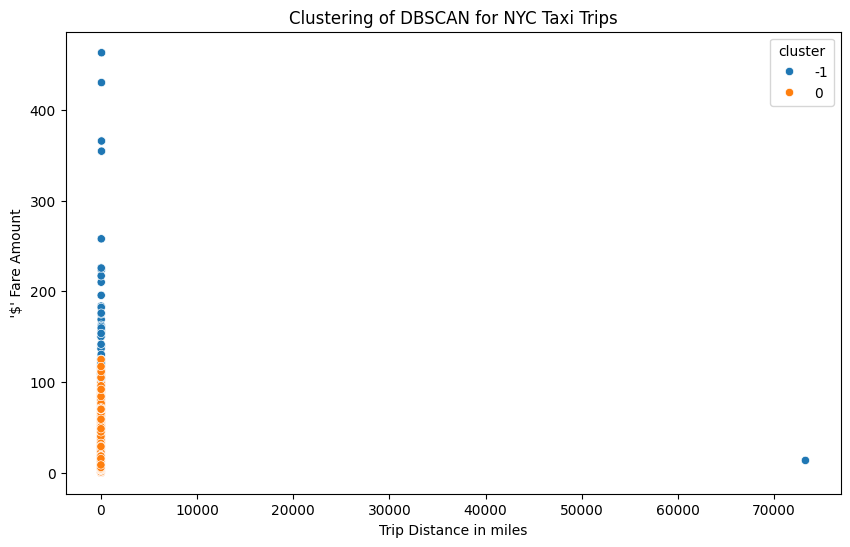

In [311]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=sample_data["trip_distance"], y=sample_data["fare_amount"], hue=sample_data["cluster"], palette="tab10")
plt.title("Clustering of DBSCAN for NYC Taxi Trips")
plt.xlabel("Trip Distance in miles")
plt.ylabel(" '$' Fare Amount ")
plt.show()

In [312]:
import pickle
with open('/Users/pratikaher01/Documents/dic_project/CSE587Project/saved_models/dbscan_model.pkl', 'wb') as f:
    pickle.dump(dbscan, f)


# Using Multinomial Logistic Regression to Predict Payment Type 

In [561]:
assembler = VectorAssembler(
    inputCols=["trip_distance", "fare_amount", "tip_amount"],
    outputCol="features_unscaled"
)

In [563]:
assembled = assembler.transform(data)

In [565]:
assembled = assembled.dropna(subset=["payment_type"])


In [567]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features_unscaled",    
    outputCol="scaled_features",
    withStd=True,
    withMean=False
)


In [569]:
scaler_model = scaler.fit(assembled)
assembled = scaler_model.transform(assembled)


In [571]:
train_data, test_data = assembled.randomSplit([0.7, 0.3], seed=42)


In [573]:

train_data = train_data.withColumn("scaled_features_array", vector_to_array("scaled_features"))

test_data = test_data.withColumn("scaled_features_array", vector_to_array("scaled_features"))

train_data = train_data.filter((array_max("scaled_features_array") != 0) | (array_min("scaled_features_array") != 0))


test_data = test_data.filter((array_max("scaled_features_array") != 0) | (array_min("scaled_features_array") != 0))


In [575]:

lr = LogisticRegression(
    labelCol="payment_type",
    featuresCol="scaled_features",  
    family="multinomial"
)


In [577]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .build()


In [579]:
crossval_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=MulticlassClassificationEvaluator(labelCol="payment_type", metricName="accuracy"),
    numFolds=3
)


In [581]:
train_data = train_data.sample(fraction=0.1, seed=42)  # 10% of training data

In [583]:
cvModel_payment = crossval_lr.fit(train_data)

In [584]:
predictions_payment_cv = cvModel_payment.transform(test_data)
evaluator_payment = MulticlassClassificationEvaluator(labelCol="payment_type", metricName="accuracy")
accuracy_payment_cv = evaluator_payment.evaluate(predictions_payment_cv)
print(f"  Payment Type Prediction Accuracy using Cross Validation: {accuracy_payment_cv:.2f}")

  Payment Type Prediction Accuracy using Cross Validation: 0.85


In [585]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="payment_type", predictionCol="prediction", metricName="accuracy")
accuracy_lr_cv = evaluator_accuracy.evaluate(predictions_payment_cv)
print(f" Accuracy of Logistic Regression Model After Tuning: {accuracy_lr_cv:.2f}")


 Accuracy of Logistic Regression Model After Tuning: 0.85


In [586]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="payment_type", predictionCol="prediction", metricName="f1")
f1_lr_cv = evaluator_f1.evaluate(predictions_payment_cv)
print(f"Logistic Regression Model F1 Score After Tuning: {f1_lr_cv:.2f}")

Logistic Regression Model F1 Score After Tuning: 0.82


In [587]:
evaluator_precision = MulticlassClassificationEvaluator(labelCol="payment_type", predictionCol="prediction", metricName="weightedPrecision")
precision_lr_cv = evaluator_precision.evaluate(predictions_payment_cv)
print(f"Logistic Regression Model Precision After Tuning: {precision_lr_cv:.2f}")

Logistic Regression Model Precision After Tuning: 0.80


In [588]:
evaluator_recall = MulticlassClassificationEvaluator(labelCol="payment_type", predictionCol="prediction", metricName="weightedRecall")
recall_lr_cv = evaluator_recall.evaluate(predictions_payment_cv)
print(f"Logistic Regression Model Recall After Tuning: {recall_lr_cv:.2f}")

Logistic Regression Model Recall After Tuning: 0.85


In [589]:
lr_model = lr.fit(train_data)

In [590]:
predictions_lr = lr_model.transform(test_data)

In [591]:
predictions_lr.select("payment_type", "prediction", "probability").show(10)

+------------+----------+--------------------+
|payment_type|prediction|         probability|
+------------+----------+--------------------+
|           1|       1.0|[0.04693365397223...|
|           1|       2.0|[0.20057938570162...|
|           2|       2.0|[0.10560870697622...|
|           1|       1.0|[0.06159476862666...|
|           1|       2.0|[0.28343647886750...|
|           1|       2.0|[0.20470125613239...|
|           1|       2.0|[0.16007087741439...|
|           1|       1.0|[5.75438312151486...|
|           2|       2.0|[0.10922963848495...|
|           1|       1.0|[0.07764717055542...|
+------------+----------+--------------------+
only showing top 10 rows



In [592]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="payment_type",
    predictionCol="prediction",
    metricName="accuracy"
)


In [593]:
lr_accuracy = evaluator.evaluate(predictions)
print(f" Accuracy for model Logistic regression: {lr_accuracy:.2f}")

 Accuracy for model Logistic regression: 0.76


In [594]:
best_lr_model = cvModel_payment.bestModel

print("Parameters best for Logistic Regression:")


print(f"  • reg Param: {best_lr_model.getOrDefault('regParam')}")

print(f"  • elastic Net Param: {best_lr_model.getOrDefault('elasticNetParam')}")
print(f"  • max Iterations: {best_lr_model.getOrDefault('maxIter')}")


Parameters best for Logistic Regression:
  • reg Param: 0.01
  • elastic Net Param: 1.0
  • max Iterations: 100


In [595]:
lr_model.write().overwrite().save("/Users/pratikaher01/Documents/dic_project/CSE587Project/saved_models/logistic_regression_model")

In [596]:
with open("/Users/pratikaher01/Documents/dic_project/CSE587Project/outputs/metrics/lr_accuracy.txt", "w") as f:
    f.write(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")

In [613]:
predictions_lr.write.mode("overwrite").parquet("/Users/pratikaher01/Documents/dic_project/CSE587Project/outputs/lr_predictions.parquet")

25/04/28 21:27:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/04/28 21:27:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/04/28 21:27:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/04/28 21:27:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/04/28 21:27:20 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/04/28 21:27:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/04/28 21:27:21 WARN MemoryManager: Total allocation exceeds 95.0